Prevendo as Notas do Enem de 2016



In [0]:
# Importando todas as Bibliotecas a serem utilizadas no projeto
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import numpy as np
import sklearn.metrics as metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Explorando e conhecendo o dataset

In [0]:
#importando os dados de treino
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [0]:
#importando os dados de teste
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [0]:
#definindo os datasets
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')



In [0]:
df_train.head() # verificando a base de treino

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,...,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,1,4314902.0,Porto Alegre,43.0,RS,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0,5.0,1.0,0.0,0.0,5,5,0,5,5,5,5,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,1,2304707.0,Granja,23.0,CE,2,0,2,1.0,0,23005157.0,2304707.0,Granja,23.0,CE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,1,1,1,1,1,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,3,1,2304400.0,Fortaleza,23.0,CE,3,0,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,A,A,A,A,A,B,A,A,B,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,5,5,5,5,5,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,0,1,3304557.0,Rio de Janeiro,33.0,RJ,1,9,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,B,B,A,B,A,B,C,A,B,D,B,C,B,C,F,C,2.0,0.0,5.0,5.0,5.0,5,5,5,5,2,5,5,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,2,1,1505304.0,Oriximiná,15.0,PA,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,B,A,A,A,A,B,A,A,B,A,A,A,B,F,D,5.0,4.0,3.0,5.0,4.0,5,5,4,3,1,4,5,NaN,A,A,A,A,A,A,A,A,A


In [0]:
df_test.head() # verificando a base de teste

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01abbb7f1a90505385f44eec9905f82ca2a42cfd,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,464.8,443.5,431.8,0,1.0,120.0,80.0,80.0,100.0,40.0,420.0,B,A,C,A,A,C,C,A
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,f48d390ab6a2428e659c37fb8a9d00afde621889,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,391.1,491.1,548.0,1,1.0,120.0,120.0,120.0,120.0,100.0,580.0,E,B,C,B,B,B,F,A
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,3.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,595.9,622.7,613.6,0,1.0,80.0,40.0,40.0,80.0,80.0,320.0,E,E,D,B,B,A,NaN,A
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,G,B,B,A,NaN,A
4,715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,1.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,942ab3dc020af4cf53740b6b07e9dd7060b24164,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,767a32545304ed293242d528f54d4edb1369f910,592.9,492.6,571.4,1,1.0,100.0,80.0,60.0,80.0,0.0,320.0,D,H,H,C,B,A,NaN,A


Verificando qual a correlação dos dados do dataset de treino

In [0]:
correlacoes = df_train.corr()

In [0]:
features = correlacoes[(correlacoes['NU_NOTA_MT']<=-0.3) | (correlacoes['NU_NOTA_MT'] >=0.3) & (correlacoes['NU_NOTA_MT'] <1.0)]['NU_NOTA_MT']
features

TP_DEPENDENCIA_ADM_ESC    0.373233
NU_NOTA_CN                0.584941
NU_NOTA_CH                0.529594
NU_NOTA_LC                0.494695
NU_NOTA_COMP2             0.335638
NU_NOTA_COMP3             0.350307
NU_NOTA_COMP4             0.342282
NU_NOTA_COMP5             0.343337
NU_NOTA_REDACAO           0.379376
Name: NU_NOTA_MT, dtype: float64

Vamos plotar o heatmap() para ver a correlação

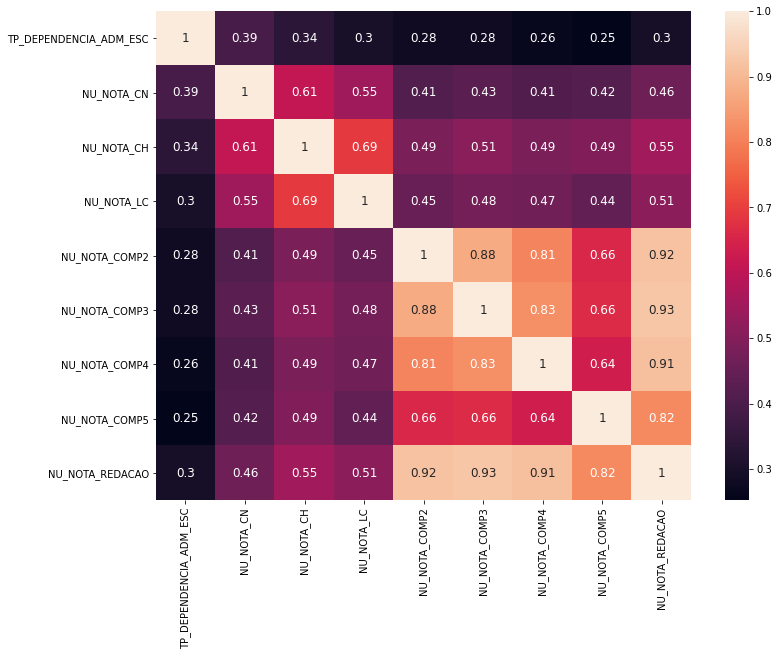

In [0]:
#plotando heatmap

features_list = features.index.to_list()
corr = df_train[features_list].corr()
ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr, annot=True, annot_kws={'size':12})

Verificar se existem valores nulos

In [0]:
df_train[features_list].isnull().sum()


TP_DEPENDENCIA_ADM_ESC    9448
NU_NOTA_CN                3389
NU_NOTA_CH                3389
NU_NOTA_LC                3597
NU_NOTA_COMP2             3597
NU_NOTA_COMP3             3597
NU_NOTA_COMP4             3597
NU_NOTA_COMP5             3597
NU_NOTA_REDACAO           3597
dtype: int64

In [0]:
# verificar quantos valores nulos em NU_NOTA_MT
df_train['NU_NOTA_MT'].isnull().sum()

3597

In [0]:
# Acidcionar a nota de matematica a lista de features a ser processada
features_list.append('NU_NOTA_MT')


Podemos fazer alguns testes aqui:
1) preencher os valores nulos com zeros
2) Preencher os valores com a média dos valores

OBS: O Dataset já possui poucos registros, portanto a remoção de registros nulos não será uma opção viável


In [0]:
#preencher com zeros
df1_train = df_train.copy()
df1_test  = df_test.copy()


In [0]:
def zeroFill(data):
    for item in features_list:
        data[item] = data[item].fillna(0)
    return data

In [0]:
df1_train = zeroFill(df1_train)

In [0]:
df1_train = zeroFill(df1_train)

In [0]:
df1_test = df1_test.fillna(0)

Preencher com a média


In [0]:
df2_train = df_train.copy()
df2_test = df_test.copy()

In [0]:
def meanFill(data):
    for item in features_list:
        data[item] = data[item].fillna(data[item].mean())
    return data

In [0]:
df2_train = meanFill(df2_train)

In [0]:
df2_test = df1_test.fillna(df2_test.mean())

**Testando algoritmos**

Para esse problema, irei testar os seguintes algoritmos: </br>

**LinearRegression**: A regressão linear é um modelo estatístico que examina a relação linear entre duas variáveis (regressão linear simples) ou mais (regressão linear múltipla) - uma variável dependente e variável (s) independente (s). O relacionamento linear basicamente significa que quando uma (ou mais) variáveis independentes aumentam (ou diminuem), a variável dependente também aumenta (ou diminui)
**KNeighborsRegressor**: O algoritmo KNN pode ser usado para problemas de classificação e regressão. O algoritmo KNN usa 'similaridade de recurso' para prever os valores de quaisquer novos pontos de dados. Isso significa que o novo ponto recebe um valor com base na proximidade com os pontos no conjunto de treinamento.</br>
**DecisionTreeRegressor**: A árvore de decisão constrói modelos de regressão ou classificação na forma de uma estrutura em árvore. Ele divide um conjunto de dados em subconjuntos cada vez menores e, ao mesmo tempo, uma árvore de decisão associada é desenvolvida de forma incremental. O resultado final é uma árvore com nós de decisão e nós de folha.</br>
**GradientBoostRegressor**: "Boost" no aprendizado de máquina é uma maneira de combinar vários modelos simples em um único modelo composto. É também por isso que o reforço é conhecido como modelo aditivo, uma vez que modelos simples (também conhecidos como aprendizes fracos) são adicionados um de cada vez, mantendo inalteradas as árvores existentes no modelo. À medida que combinamos modelos cada vez mais simples, o modelo final completo se torna um preditor mais forte. O termo "gradiente" em "aumento de gradiente" vem do fato de o algoritmo usar descida de gradiente para minimizar a perda.</br>
**RandomForestRegressor**: Também é um modelo que funciona através da técnica ensemble, que combina as previsões de vários algoritmos de aprendizado de máquina para fazer previsões mais precisas do que qualquer modelo individual. Esse modelo combina várias árvores de decisão que são executadas em paralelo. Não há interação entre essas árvores durante a construção das árvores.

In [0]:
# Criando um dataset de respostas
df_result = pd.DataFrame()

In [0]:
#Adicionando número de inscrição a ser salvo no arquivo de resposta final
df_result['NU_INSCRICAO'] = df_test['NU_INSCRICAO']



In [0]:
# REMOVENDO A VARIÁVEL TARGET
features_list.remove('NU_NOTA_MT')


USANDO O DATASET PREENCHIDO COM ZEROS

In [0]:
def validaPerformanceModelos(pipelines,x_train,y_train):
    results = []
    names = []
    for name, model in pipelines:
        kfold = KFold(n_splits=5, random_state=21, shuffle=True)
        cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)


In [0]:
pipelines = []
pipelines.append(('LR', Pipeline([('Scaler', MinMaxScaler()),('LR',LinearRegression())])))
pipelines.append(('KNN', Pipeline([('Scaler', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('DTR', Pipeline([('Scaler', MinMaxScaler()),('DTR', DecisionTreeRegressor())])))
pipelines.append(('GBM', Pipeline([('Scaler', MinMaxScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('RFR', Pipeline([('Scaler', MinMaxScaler()),('RFR', RandomForestRegressor())])))

In [0]:
x_train = df1_train[features_list]
y_train = df1_train['NU_NOTA_MT']
x_test = df1_test[features_list]

In [0]:
validaPerformanceModelos(pipelines, x_train, y_train)

LR: -5101.872087 (135.658620)
KNN: -5041.330622 (39.766364)
DTR: -8384.326487 (312.306330)
GBM: -4053.190459 (47.451954)
RFR: -4346.313011 (88.554842)


Os algoritmos com a melhor performance foram o GradientBoostingRegressor e o RandomForestRegressor (possuem um valor de erro médio menor), portanto irei gerar os arquivos de resposta para testar no site do Codenation

GradientBoostRegressor:

In [0]:
pipe_GBM = Pipeline([('scaler',  StandardScaler()),
            ('GradientBoostingRegressor', GradientBoostingRegressor())])

In [0]:
CV_pipe_GBM = RandomizedSearchCV(estimator = pipe_GBM, param_distributions = {},cv = 5,return_train_score=True, verbose=0)

In [0]:
CV_pipe_GBM.fit(x_train, y_train)
ypred = CV_pipe_GBM.predict(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [0]:
df_result['NU_NOTA_MT'] = np.around(ypred,2)

In [0]:
df_result.to_csv('answer.csv', index=False, header=True)
df_result.head()

,NU_INSCRIÇÃO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,433.92
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,454.04
2,b38a03232f43b11c9d0788abaf060f7366053b6d,584.56
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.52
4,715494628a50142ce8cb17191cfe6d0f3cae0934,538.07


In [0]:

files.download('answer.csv')